# North Atlantic O2 gapfill
    - O2 is estimated as a function of T, S, Stratification, long, lat, and time using one of the ML method
    - It generates comparison of full model and estimated O2 for all months
    - RMSE and correlation are calculated and displayed
    - Domain-mean O2 time series is calculated and displayed

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import sklearn as skl
import gsw
import cartopy.crs as ccrs

### First prepare O2, T, S, stratification data

In [2]:
# access model output
model = 'GFDL-ESM4'
dir = '/glade/work/ito/dataset/model/'+model+'/'
dira= '/glade/work/acervania/dataset/model/'+model+'/'
ds0=xr.open_dataset(dir+'o2_'+model+'_196501-201412_subsampled.nc')
ds1=xr.open_dataset(dir+'so_'+model+'_196501-201412_subsampled.nc')
ds2=xr.open_dataset(dir+'thetao_'+model+'_196501-201412_subsampled.nc')
ds3=xr.open_dataset(dira+'Nsquared_MLD_'+model+'_196501-201412_subsampled.nc')

In [3]:
# basin mask
dsm=xr.open_dataset('/glade/work/ito/dataset/model/basin_mask_01.nc')
# observation coordinates
dsd=xr.open_dataset('/glade/work/ito/dataset/model/mask_woagrid_196501-201412.nc')

In [4]:
# select depth level
zlev=500

In [5]:
# get coordinates
x=ds0.lon.to_numpy()
y=ds0.lat.to_numpy()
xi=np.arange(0,360,1)
yi=np.arange(0,180,1)
xx,yy=np.meshgrid(x,y)
xxi,yyi=np.meshgrid(xi,yi)

In [6]:
# extract data in the Atlantic basin at 500m depth
mask= dsm.basin_mask.sel(depth=zlev)
o2 = ds0.o2.sel(depth=zlev)*1e3
so = ds1.so.sel(depth=zlev)
to = ds2.thetao.sel(depth=zlev)
dr = ds3.Nsquared.sel(depth=zlev)
mld= ds3.MLD.sel(depth=zlev)

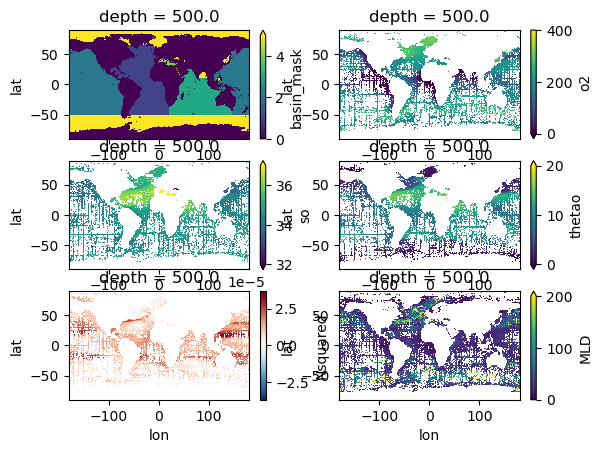

In [7]:
# take a look at the data
fig,ax=plt.subplots(3,2)
mask.plot(ax=ax[0,0],vmin=0,vmax=5,label='basin_mask')
o2.mean('time').plot(ax=ax[0,1],vmin=0,vmax=400,label='O2')
so.mean('time').plot(ax=ax[1,0],vmin=32,vmax=37,label='S')
to.mean('time').plot(ax=ax[1,1],vmin=0,vmax=20,label='T')
dr.mean('time').plot(ax=ax[2,0],label='N2')
mld.mean('time').plot(ax=ax[2,1],vmin=0,vmax=200,label='MLD')

In [8]:
# select Atlantic basin
# Atlantic is mask = 1
ma = dsm.basin_mask.sel(depth=zlev).to_numpy()

### Prepare monthly climatology data so we can calculate anomalies

In [9]:
# monthly climatology
#dc0=xr.open_dataset('/glade/work/ito/dataset/ocean/woa/woa18_all_o00_01.nc',decode_times=False)
#dc1=xr.open_dataset('/glade/work/ito/dataset/ocean/woa/woa18_decav_s00_01.nc',decode_times=False)
#dc2=xr.open_dataset('/glade/work/ito/dataset/ocean/woa/woa18_decav_t00_01.nc',decode_times=False)
dc0=xr.open_dataset(dir+'o2_'+model+'_196501-201412.nc')
dc1=xr.open_dataset(dir+'so_'+model+'_196501-201412.nc')
dc2=xr.open_dataset(dir+'thetao_'+model+'_196501-201412.nc')
dc3=xr.open_dataset(dira+'Nsquared_MLD_'+model+'_196501-201412.nc')

In [10]:
# extract 500m climatology
o2c=dc0.o2.sel(depth=zlev).groupby('time.month').mean('time')*1e3
soc=dc1.so.sel(depth=zlev).groupby('time.month').mean('time')
toc=dc2.thetao.sel(depth=zlev).groupby('time.month').mean('time')
drdzc=dc3.Nsquared.sel(depth=zlev).groupby('time.month').mean('time')
mldc=dc3.MLD.sel(depth=zlev).groupby('time.month').mean('time')

In [11]:
# subtract climatology from the discrete data to define anomalies
doa=o2.groupby('time.month')-o2c
dsa=so.groupby('time.month')-soc
dta=to.groupby('time.month')-toc
dra=dr.groupby('time.month')-drdzc
dha=mld.groupby('time.month')-mldc
#
# make numpy array
doa = doa.to_numpy()
dsa = dsa.to_numpy()
dta = dta.to_numpy()
dra = dra.to_numpy()
dha = dha.to_numpy()
#
# prepare lat lon time data
xx1 = np.tile(xx,[600,1,1])
yy1 = np.tile(yy,[600,1,1])
tt0 = np.tile(np.arange(0,600,1),[180,360,1])
tt1 = np.transpose(tt0,(2,0,1))

In [12]:
# apply mask for the north atlantic
doa=np.where((ma==1)&(yy>0),doa,np.nan)
dsa=np.where((ma==1)&(yy>0),dsa,np.nan)
dta=np.where((ma==1)&(yy>0),dta,np.nan)
dra=np.where((ma==1)&(yy>0),dra,np.nan)
dha=np.where((ma==1)&(yy>0),dha,np.nan)

### Now we have the anormaly data for the North Atlantic. Remove NaNs and organize them into 1d array

In [13]:
# create data vector
doa0 = doa.flatten()
dsa0 = dsa.flatten()
dta0 = dta.flatten()
dra0 = dra.flatten()
dha0 = dha.flatten()
xx0  = xx1.flatten()
yy0  = yy1.flatten()
tt0  = tt1.flatten()

In [14]:
# remove nan
dd = doa0 + dsa0 + dta0 + dra0 + dha0
doa1=doa0[np.isnan(dd)==False]
dsa1=dsa0[np.isnan(dd)==False]
dta1=dta0[np.isnan(dd)==False]
dra1=dra0[np.isnan(dd)==False]
dha1=dha0[np.isnan(dd)==False]
xx1=xx0[np.isnan(dd)==False]
yy1=yy0[np.isnan(dd)==False]
tt1=tt0[np.isnan(dd)==False]
Nsample = np.size(doa1)
print(Nsample)

20329


In [15]:
# generate data matrix and standardize it
X = np.array([dsa1, dta1, dra1, dha1, xx1, yy1, tt1])
y = doa1
#
Xm = np.mean(X,axis=1)
Xstd = np.std(X,axis=1)
#
N=np.size(y)
# normalize x and y
Xa = (X.T - Xm)/Xstd
ym = np.mean(y)
ystd = np.std(y)
ya = (y-ym)/ystd

## ML

### First split the data into training and test set

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xa, ya,random_state=1)

### Support Vector Machine estimator (SVregr)

In [17]:
##
## Support Vector Regression
##
import sklearn.svm as svm

In [18]:
SVregr = svm.SVR(C=9,epsilon=0.2)
SVregr.fit(X_train, y_train)

SVR(C=9, epsilon=0.2)

In [19]:
out = SVregr.predict(X_test)
SVregr.score(X_test, y_test)

0.7202520711829387

correlation =  0.849549443159944
RMSE =  4.345913851237346


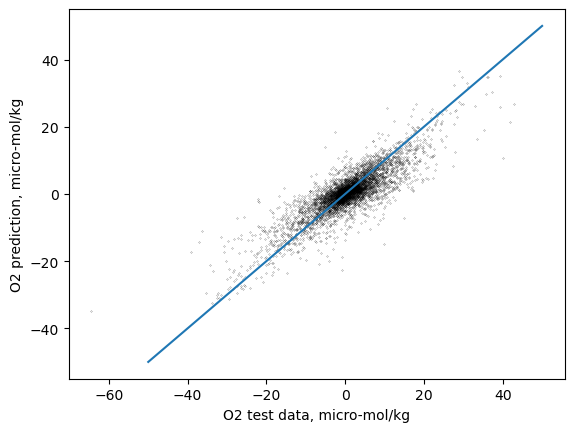

In [20]:
o2est = out*ystd + ym
o2test= y_test*ystd + ym
#
plt.plot(o2test,o2est,'k.',markersize=.3)
plt.plot([-50,50],[-50,50])
plt.ylabel('O2 prediction, micro-mol/kg')
plt.xlabel('O2 test data, micro-mol/kg')
temp=np.corrcoef(o2est,o2test)
Rval_SV=temp[0,1]
print('correlation = ',Rval_SV)
RMSE_SV=np.sqrt(np.mean((o2est-o2test)**2))
print('RMSE = ',RMSE_SV)

### Neural Network estimator (SNNregr)

In [21]:
## NN
from sklearn.neural_network import MLPRegressor

In [36]:
NNregr = MLPRegressor(hidden_layer_sizes=(40,40,40,40),alpha=0.01, 
                      random_state=1, max_iter=1000).fit(X_train, y_train)

In [37]:
out = NNregr.predict(X_test)
NNregr.score(X_test, y_test)

0.7880541941469599

correlation =  0.8878704102068459
RMSE =  3.7827712944919143


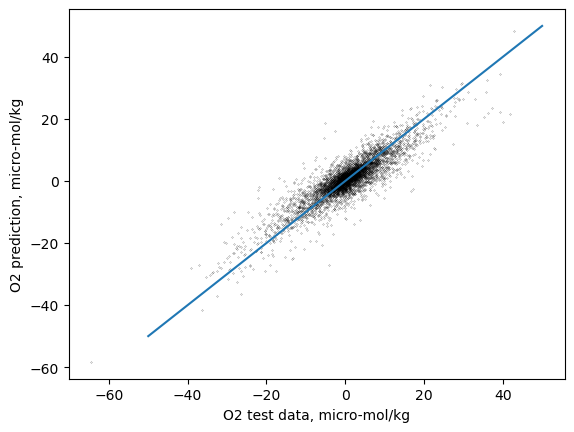

In [38]:
o2est = out*ystd + ym
o2test= y_test*ystd + ym
#
plt.plot(o2test,o2est,'k.',markersize=.3)
plt.plot([-50,50],[-50,50])
plt.ylabel('O2 prediction, micro-mol/kg')
plt.xlabel('O2 test data, micro-mol/kg')
temp=np.corrcoef(o2est,o2test)
Rval_NN=temp[0,1]
print('correlation = ',Rval_NN)
RMSE_NN=np.sqrt(np.mean((o2est-o2test)**2))
print('RMSE = ',RMSE_NN)

In [39]:
# plot the loss function (optional)
#plt.plot(NNregr.loss_curve_)
#plt.xlabel('Iteration')
#plt.ylabel('Loss function')

## mapping O2 for all year and month

In [40]:
# apply basin mask 
def apply_basinmask(datain):
    dataout=np.where((ma==1)&(yy>0),datain,np.nan)
    return dataout

In [41]:
# get input data from full model
def get_inputdata(zlev,it,month):
    soa=dc1.so.isel(time=it).sel(depth=zlev)-soc[month-1,:,:]
    toa=dc2.thetao.isel(time=it).sel(depth=zlev)-toc[month-1,:,:]
    o2a=dc0.o2.isel(time=it).sel(depth=zlev)*1e3-o2c[month-1,:,:]
    dra=dc3.Nsquared.isel(time=it).sel(depth=zlev)-drdzc[month-1,:,:]
    dha=dc3.MLD.isel(time=it).sel(depth=zlev)-mldc[month-1,:,:]
    return soa,toa,o2a,dra,dha

In [42]:
# generate data matrix
def gen_datamatrix(y,xi,yi,it,x1,x2,x3,x4,x5,x6):
    Y0 = y.flatten()
    X1 = x1.flatten()
    X2 = x2.flatten()
    X3 = x3.flatten()
    X4 = x4.flatten()
    X5 = x5.flatten()
    X6 = x6.flatten()
    tt0  = np.ones((180,360))*it
    X7 = tt0.flatten()
    xxi = xi.flatten()
    yyi = yi.flatten()
    # remove nan
    dd = Y0+X1+X2+X3+X4+X5+X6
    Y1=Y0[np.isnan(dd)==False]
    X11=X1[np.isnan(dd)==False]
    X21=X2[np.isnan(dd)==False]
    X31=X3[np.isnan(dd)==False]
    X41=X4[np.isnan(dd)==False]
    X51=X5[np.isnan(dd)==False]
    X61=X6[np.isnan(dd)==False]
    X71=X7[np.isnan(dd)==False]
    #
    Xi=xxi[np.isnan(dd)==False]
    Yi=yyi[np.isnan(dd)==False]
    # Normalize data
    # generate data matrix and standardize it
    X = np.array([X11, X21, X31, X41, X51, X61, X71])
    Xa = (X.T - Xm)/Xstd
    Nsample = np.size(X11)
    #print(Nsample)
    return Xa,Y1,Xi,Yi

In [55]:
zo=dc0.depth.to_numpy()
o2est=np.zeros((600,180,360))
o2ful=np.zeros((600,180,360))
RMSE=np.zeros(600,)
R=np.zeros(600,)
o2inv=np.zeros((600,2))
#
for year in np.arange(1965,2015,1):
    if year%10 == 5:
        print('year = '+str(year))
    for month in np.arange(1,13,1):
        #year = 2010
        #month = 3
        it = month+(year-1965)*12-1
        soa,toa,o2a,dra,dha = get_inputdata(zlev,it,month)
        # apply mask
        doa=apply_basinmask(o2a)
        soa=apply_basinmask(soa)
        toa=apply_basinmask(toa)
        dra=apply_basinmask(dra)
        dha=apply_basinmask(dha)
        # generate data matrix
        Xa,Y,xi,yi=gen_datamatrix(doa,xxi,yyi,it,soa,toa,dra,dha,xx,yy)
        Nsample=np.size(Y)
        # projection
        out = NNregr.predict(Xa)
        #out = SVregr.predict(Xa)
        # map it back to lon-lat grid
        temp = np.nan*np.zeros((180,360))
        for n in range(Nsample):
            temp[yi[n],xi[n]]=out[n]
        o2est[it,:,:] = temp*ystd + ym
        o2ful[it,:,:] = doa
        RMSE[it]=np.sqrt(np.mean((out*ystd+ym-Y)**2))
        temp=np.corrcoef(Y,out)
        R[it]=temp[0,1]
        o2inv[it,0]=np.nanmean(Y)
        o2inv[it,1]=np.nanmean(out)*ystd+ym

year = 1965
year = 1975
year = 1985
year = 1995
year = 2005


Text(0.5, 0, 'time')

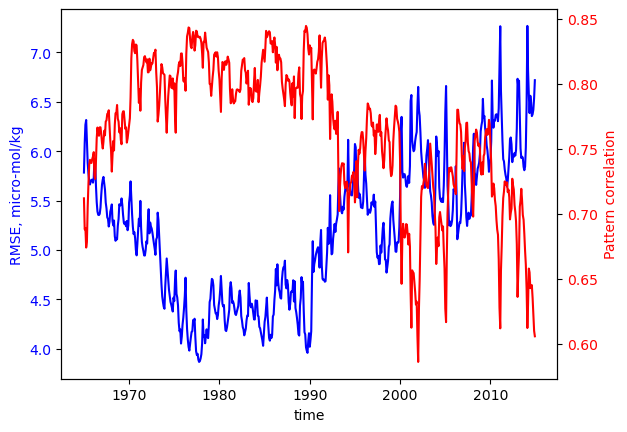

In [56]:
t=ds0.time
# display 2 variables together
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
#
ax1.plot(t,RMSE,'b-')
ax1.set_ylabel('RMSE, micro-mol/kg', color='b')
ax1.tick_params(axis='y',labelcolor='b')
#
ax2.plot(t,R,'r-')
ax2.set_ylabel('Pattern correlation', color='r')
ax2.tick_params(axis='y',labelcolor='r')
#
ax1.set_xlabel('time')

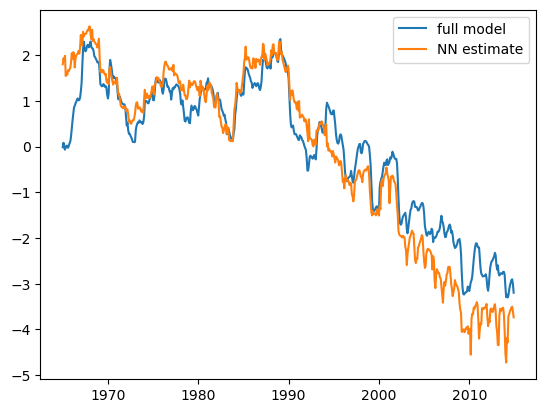

In [57]:
plt.plot(t,o2inv[:,0],label='full model')
plt.plot(t,o2inv[:,1],label='NN estimate')
plt.legend()

In [58]:
import cartopy.crs as ccrs
da0=xr.DataArray(data=o2ful,name='o2ful',dims=['time','lat','lon'],
                 coords={'time':t,'lat':ds0.lat,'lon':ds0.lon})
da1=xr.DataArray(data=o2est,name='o2est',dims=['time','lat','lon'],
                 coords={'time':t,'lat':ds0.lat,'lon':ds0.lon})
ds=da0.to_dataset()
ds['o2est']=da1
ds.to_netcdf('O2_NA_NN_'+model+'_monthly.nc')

In [61]:
estimator='NN'
#
for year in np.arange(1965,2015,1):
    for month in np.arange(1,13,1):
        #
        it=12*(year-1965)+month-1
        dat = dsd.isel(time=it).sel(depth=zlev)
        #
        # open figure 4 panels
        #fig,ax=plt.subplots(2,2)
        #
        # full model
        fig = plt.figure()
        ax1 = fig.add_subplot(2,2,1)
        ax1.pcolormesh(xx,yy,o2ful[it,:,:],vmin=-30,vmax=30,cmap='RdBu_r')
        dpos=dat.mask.to_numpy()
        xxx=np.where((ma==1)&(yy>0),xx,np.nan)
        yyy=np.where((ma==1)&(yy>0),yy,np.nan)
        xpos=xxx[dpos==1]
        ypos=yyy[dpos==1]
        ax1.scatter(xpos, ypos, s=20, facecolors='none', edgecolors='k')
        ax1.set_xlim(-100,20)
        ax1.set_ylim(0,70)
        ax1.set_title(model+': year='+str(year)+'-'+str(month))
        ax1.set_xticks([])
        #
        # NN estimate
        ax2 = fig.add_subplot(2,2,2)
        ax2.pcolormesh(xx,yy,o2est[it,:,:],vmin=-30,vmax=30,cmap='RdBu_r')
        ax2.set_xlim(-100,20)
        ax2.set_ylim(0,70)
        ax2.set_title(estimator)
        ax2.set_xticks([])
        #
        # global inventory time series
        ax3 = fig.add_subplot(2,2,3)
        ax3.plot(t,o2inv[:,0],'b-',label='full model',linewidth=.3)
        ax3.plot(t,o2inv[:,1],'r-',label=estimator+' estimate',linewidth=.3)
        ax3.plot(t[it],o2inv[it,0],'bo')
        ax3.plot(t[it],o2inv[it,1],'ro')
        ax3.legend()
        ax3.set_xlabel('time')
        ax3.set_ylabel('domain mean O2')
        #
        ax4 = fig.add_subplot(2,2,4)
        ax4.plot(t,R,'b-',linewidth=.3,label='pattern corr.')
        ax4.plot(t[it],R[it],'bo')
        ax4.legend()
        #ax[1,1].set_ylabel('Pattern correlation', color='b')
        ax4.tick_params(axis='y',labelcolor='b')
        ax4.set_xlabel('time')
        fig.savefig('figure/frame_'+estimator+'_'+str(it)+'.png')
        plt.close()